In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import clear_output

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2
import json
import itertools
import math
import os
import requests
import shap
import tarfile

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics
import tensorflow as tf

from typing import Any, Optional

SEED = 42
np.random.seed(SEED)
tf.keras.backend.set_epsilon(1e-7)
tf.random.set_seed(SEED)

2024-05-21 19:30:35.072786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
models = {
    'VGG16': (224, 224),
    'ResNet50': (224, 224),
    'InceptionV3': (299, 299),
    'InceptionResnetV2': (299, 299),
    'Xception': (299, 299),
    'EfficientNetB3': (300, 300),
    'EfficientNetB7': (600, 600)
}

base = 'InceptionV3'  # VGG16, ResNet50, InceptionV3, InceptionResnetV2, Xception, EfficientNetB3, EfficientNetB7
img_height, img_width = models[base]

if tf.keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_height, img_width)
else:
    input_shape = (img_height, img_width, 3)

batch_size = 16
epochs = 30
cv_folds = 5
test_size = None  # Set to None to perform a KFold CV
classes = {
    1: 'fertile',
    0: 'infertile'
}

# Save these images for prediction and filtering/heatmap
pred_images = [
    'fertile/fertile-51.png',
    'infertile/infertile-65.png',
    'fertile/fertile-41.png',
    'infertile/infertile-64.png'
]
# If we need to download the images from it's repository
download_images = True
# If the model is already fitted then we just need to load it's weights
fit_model = True

path = 'files'  # Relative path for new files and images generation
img_path = f'{path}/cm_dataset'  # Folder in which all the images are stored
cv_path = f'{path}/cv'  # Folder for checkpoints and graphics from CV folds

input_shape

(299, 299, 3)

In [19]:
def plot_image(
    images: Any,
    cmap: str = 'gray',
    ncols: int = 2,
    title: Optional[str] = None,
    show: bool = True,
    path: Optional[str] = None
) -> None:
    if isinstance(images, (list, tuple)):
        images = {str(i): img for i, img in enumerate(images)}
    elif not isinstance(images, dict):
        images = {'': images}

    nrows = int(math.ceil(float(len(images)) / float(ncols)))
    width = 20
    height = 6 * nrows

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), constrained_layout=True)
    axes = ax.flatten()

    i = 0
    for header, image in images.items():
        axes[i].imshow(image, cmap=cmap)
        
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(header)
        
        i += 1

    f_axes = fig.axes
    for a in f_axes[len(images):len(axes)]:
        a.set_axis_off()

    if title is not None:
        plt.suptitle(title)

    fig.tight_layout()
    if show:
        plt.show()
    if path:
        fig.savefig(path)
    plt.close()


def get_df_images(
    df: pd.DataFrame,
    n: Optional[int] = None
) -> tuple:
    x = []
    y = []
    
    if n is None or n > df.shape[0]:
        n = df.shape[0]

    for i in np.arange(n):
        a, b = df.iloc[i].values

        a = tf.keras.utils.load_img(f'{img_path}/{a}', target_size=(img_width, img_height))
        a = tf.keras.utils.img_to_array(a).astype('uint8')
        b = int(b)

        x.append(a)
        y.append(b)

    x = np.array(x)
    y = np.array(y)

    return x, y


def get_generator_images(
    generator: tf.keras.preprocessing.image.ImageDataGenerator,
    n: Optional[int] = None
) -> tuple:
    x = []
    y = []
    generator.reset()

    if n is None:
        n = generator.samples

    n_iter = int(math.ceil(float(n) / float(generator.batch_size)))

    for _ in np.arange(n_iter):
        a, b = generator.next()
    
        x.extend(a)
        y.extend(b)

    x = np.array(x)[:n]
    y = np.array(y)[:n]

    return x, y


def compute_grad_cam(
    model: tf.keras.Model,
    image: np.ndarray,
    layer_name: Optional[str] = None
) -> np.ndarray:
    """
    Compute the Grad-CAM map for a given image and model.
    """
    data = np.expand_dims(image, axis=0)

    if layer_name is None:
        for layer in reversed(model.layers):
            if len(layer.output_shape) == 4:
                layer_name = layer.name
                break

    if layer_name is None:
        return

    grad_model = tf.keras.Model(
        inputs=model.input,
        outputs=[
            model.get_layer(layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as g:
        conv_output, preds = grad_model(data)
        loss = preds[:, tf.argmax(preds[0])]

    grads = g.gradient(loss, conv_output)

    cast_conv_output = tf.cast(conv_output > 0, tf.float32)
    cast_grads = tf.cast(grads > 0, tf.float32)
    guided_grads = cast_conv_output * cast_grads * grads

    conv_output = conv_output[0]
    guided_grads = guided_grads[0]

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)

    h, w = data.shape[1], data.shape[2]
    heatmap = cv2.resize(cam.numpy(), (h, w))

    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + tf.keras.backend.epsilon())

    return heatmap


def overlay_grad_cam(
    heatmap: np.ndarray,
    image: np.ndarray,
    alpha: float = 0.5,
    colormap: int = cv2.COLORMAP_VIRIDIS
) -> np.ndarray:
    if np.max(heatmap) <= 1:
        heatmap = (heatmap * 255).astype('uint8')
    if np.max(image) <= 1:
        image = (image * 255).astype('uint8')

    overlay = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(image, alpha, overlay, (1 - alpha), 0)
    
    overlay = overlay / 255.
    
    return overlay


def compute_shap_map(
    shap_values: np.ndarray
) -> np.ndarray:
    heatmap = np.copy(shap_values) if len(shap_values) < 3 else shap_values.sum(-1)
    vmax = np.nanpercentile(np.abs(heatmap), 99.9)
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255, l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255, l))
    cmap = mpl.colors.LinearSegmentedColormap.from_list('red_transparent_blue', colors)
    
    norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax)
    cm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    heatmap = cm.to_rgba(heatmap)
    
    return heatmap


def precision_recall(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> tuple:
    f1 = []
    precision = []
    recall = []

    thrs = [x / 100. for x in np.arange(5, 100, 5)]

    for x in thrs:
        t_pred = np.array([1. if i > x else 0. for i in y_pred]).astype(float)
        f1.append(metrics.f1_score(y_true, t_pred, pos_label=1))
        precision.append(metrics.precision_score(y_true, t_pred, pos_label=1))
        recall.append(metrics.recall_score(y_true, t_pred, pos_label=1))

    best = np.argmax(f1)
    thr = thrs[best]

    return thr, thrs, f1, precision, recall


def draw_roc_curve(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax.plot(fpr, tpr, 'b-', label=f'AUC = {roc_auc:0.2f}')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], '--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

    return ax


def draw_precision_recall(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    thr, thrs, f1, precision, recall = precision_recall(y_true, y_pred)
    best = thrs.index(thr)

    ax.plot(thrs, precision, 'y--', label=f'Precision ({precision[best]:0.2f})')
    ax.plot(thrs, recall, 'g--', label=f'Recall ({recall[best]:0.2f})')
    ax.plot(thrs, f1, 'b-', label=f'F1 ({f1[best]:0.2f})')
    ax.legend(loc='best')
    ax.axvline(x=thr, ls='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylabel('Scores')
    ax.set_xlabel(f'Threshold ({thr:0.2f})')

    return ax


def draw_prediction_histogram(
    y_pred: np.ndarray,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    ax.hist(y_pred)
    
    ax.set_xlim([0.0, 1.0])
    
    ax.set_ylabel('Volume')
    ax.set_xlabel('Predicted')
    
    return ax


def draw_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    thr: float = 0.5,
    ax: Optional[plt.Axes] = None
) -> plt.Axes:
    y_tgt = np.array([1 if i > thr else 0 for i in y_pred])
    cm = metrics.confusion_matrix(y_true, y_tgt)

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ticks = np.arange(2)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i,
            format(cm[i, j], 'd'),
            horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

    ax.set_ylabel('Value')
    ax.set_xlabel('Predicted')

    return ax


def plot_roc_curve_cv(
    cv_true: list[np.ndarray],
    cv_pred: list[np.ndarray],
    figsize: tuple = (12, 8),
    show: bool = True,
    path: Optional[str] = None
) -> None:
    fig, ax = plt.subplots(figsize=figsize)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i in np.arange(len(cv_pred)):
        fpr, tpr, _ = metrics.roc_curve(cv_true[i], cv_pred[i])
        roc_auc = metrics.auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, alpha=0.3, label=f'Fold {i + 1} AUC = {roc_auc:0.2f}')

        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0

        tprs.append(interp_tpr)
        aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, color='blue', lw=2, alpha=0.8, label=r'Mean AUC = {:0.2f} $\pm$ {:0.2f}'.format(mean_auc, std_auc))

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2, label=r'$\pm$ 1 Std Dev')

    ax.plot([0, 1], [0, 1], color='red', ls='--', lw=2, alpha=0.4, label='Random')

    ax.legend(loc='lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title('ROC Curve CV')

    if show:
        plt.show()
    if path:
        fig.savefig(path)
    plt.close()

In [4]:
class TanhSoft(tf.keras.layers.Layer):
    """
    TanhSoft activation function.

    See https://arxiv.org/pdf/2009.03863.pdf for more details.
    """

    def __init__(
        self,
        alpha: float = 0.0,
        beta: float = 0.6,
        gamma: float = 1.0,
        delta: float = 0.0
    ):
        super().__init__()

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        return tf.keras.ops.tanh(
            self.alpha * inputs + self.beta * tf.keras.ops.exp(self.gamma * inputs)
        ) * tf.keras.ops.log(
            self.delta + tf.keras.ops.exp(inputs)
        )


class TrainingPlot(tf.keras.callbacks.Callback):
    """
    Training plot callback.
    """

    def __init__(
        self,
        path: Optional[str] = None,
        show: bool = True,
        ncols: int = 2
    ):
        super().__init__()

        self.path = path
        self.show = show
        self.ncols = ncols
        self.keys = None

    def on_train_begin(self, logs: Optional[dict] = None) -> None:
        self.epoch = 0
        self.history = {}
        self.stopped = False

    def on_epoch_end(self, epoch: int, logs: Optional[dict] = None) -> None:
        logs = logs or {}

        if self.keys is None:
            self.keys = list(logs.keys())
            self.history = {k: [] for k in self.keys}

        self.epoch = epoch + 1
        for k in self.keys:
            self.history[k].append(logs.get(k))

        self.plot_history_eval()

    def on_train_end(self, logs: Optional[dict] = None) -> None:
        self.stopped = True
        
        self.plot_history_eval()

    def plot_history_eval(self):
        if self.show:
            clear_output(wait=True)
        scores = [i for i in self.keys if not i.startswith('val_')]

        figsize = (20, 8)
        ncols = self.ncols
        nrows = math.ceil(len(scores) / ncols)
        width = figsize[0]
        height = ((len(scores) + 1) // ncols + 1) * figsize[1] / ncols

        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width, height), constrained_layout=True)
        axes = ax.flatten()

        for i, score in enumerate(scores):
            val_score = 'val_{}'.format(score)

            xticks = np.arange(1, len(self.history[score]) + 1)
            markevery = [len(xticks) - 1] if not self.stopped else []

            axes[i].plot(xticks, self.history[score], marker='o', markevery=markevery, lw=2, label=score)
            if val_score in self.keys:
                axes[i].plot(xticks, self.history[val_score], marker='o', markevery=markevery, lw=2, label=val_score)

            axes[i].set_xticks(np.arange(0, len(self.history[score]) + 1, 5))
            axes[i].set_xlabel('epoch #')
            axes[i].set_ylabel('')
            axes[i].grid(False)
            axes[i].legend(loc='best')
            if self.stopped:
                axes[i].set_title(f'{score} @ epoch {self.epoch} [END]')
            else:
                axes[i].set_title(f'{score} @ epoch {self.epoch}')

        f_axes = fig.axes
        for a in f_axes[len(scores):len(axes)]:
            a.set_axis_off()

        fig.tight_layout()
        if self.show:
            plt.show()
        if self.path:
            fig.savefig(self.path)
        plt.close()

### Download image dataset

In [5]:
os.makedirs(cv_path, exist_ok=True)  # Create CV folder if it does not exist

if download_images:
    img_url = 'https://www.dropbox.com/s/cstv2zzo3dldx1t/cm_dataset.tar.gz?dl=1'
    
    r = requests.get(img_url, stream=True)
    tarfile.open(fileobj=r.raw, mode='r|gz').extractall(path=img_path)
    
    print('Images downloaded!')
else:
    print('Download skipped!')

Images downloaded!


### Select pretrained model

In [6]:
if base == 'VGG16':
    BaseModel = tf.keras.applications.VGG16
    preprocess_input = tf.keras.applications.vgg16.preprocess_input
elif base== 'ResNet50':
    BaseModel = tf.keras.applications.ResNet50
    preprocess_input = tf.keras.applications.resnet50.preprocess_input
elif base== 'InceptionV3':
    BaseModel = tf.keras.applications.InceptionV3
    preprocess_input = tf.keras.applications.inception_v3.preprocess_input
elif base== 'InceptionResnetV2':
    BaseModel = tf.keras.applications.InceptionResNetV2
    preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
elif base== 'Xception':
    BaseModel = tf.keras.applications.Xception
    preprocess_input = tf.keras.applications.xception.preprocess_input
elif base== 'EfficientNetB3':
    BaseModel = tf.keras.applications.EfficientNetB3
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input
elif base== 'EfficientNetB7':
    BaseModel = tf.keras.applications.EfficientNetB7
    preprocess_input = tf.keras.applications.efficientnet.preprocess_input

print('{} model loaded!'.format(base))

InceptionV3 model loaded!


### Build model

Build our final model on top of our selected pretrained model. The goal is to insert an attention layer between the pretrained model and the fully connected layers. This is done to extract the most relevant information from each image.

Basically, we analyze the image pixel by pixel and assign a specific weight to each one of them so that we obtain a visual heatmap with those
areas to which we must pay attention.

After that, instead of the traditional GAP (Global Average Pooling), we use the attention layer output to perform a GWAP (Global Weighted Average Pooling) operation, capable of offering much more information in the output, with those important areas of the image highlighted.

Finally, we add a fully connected layer to the model in order to classify the image as fertile or infertile.

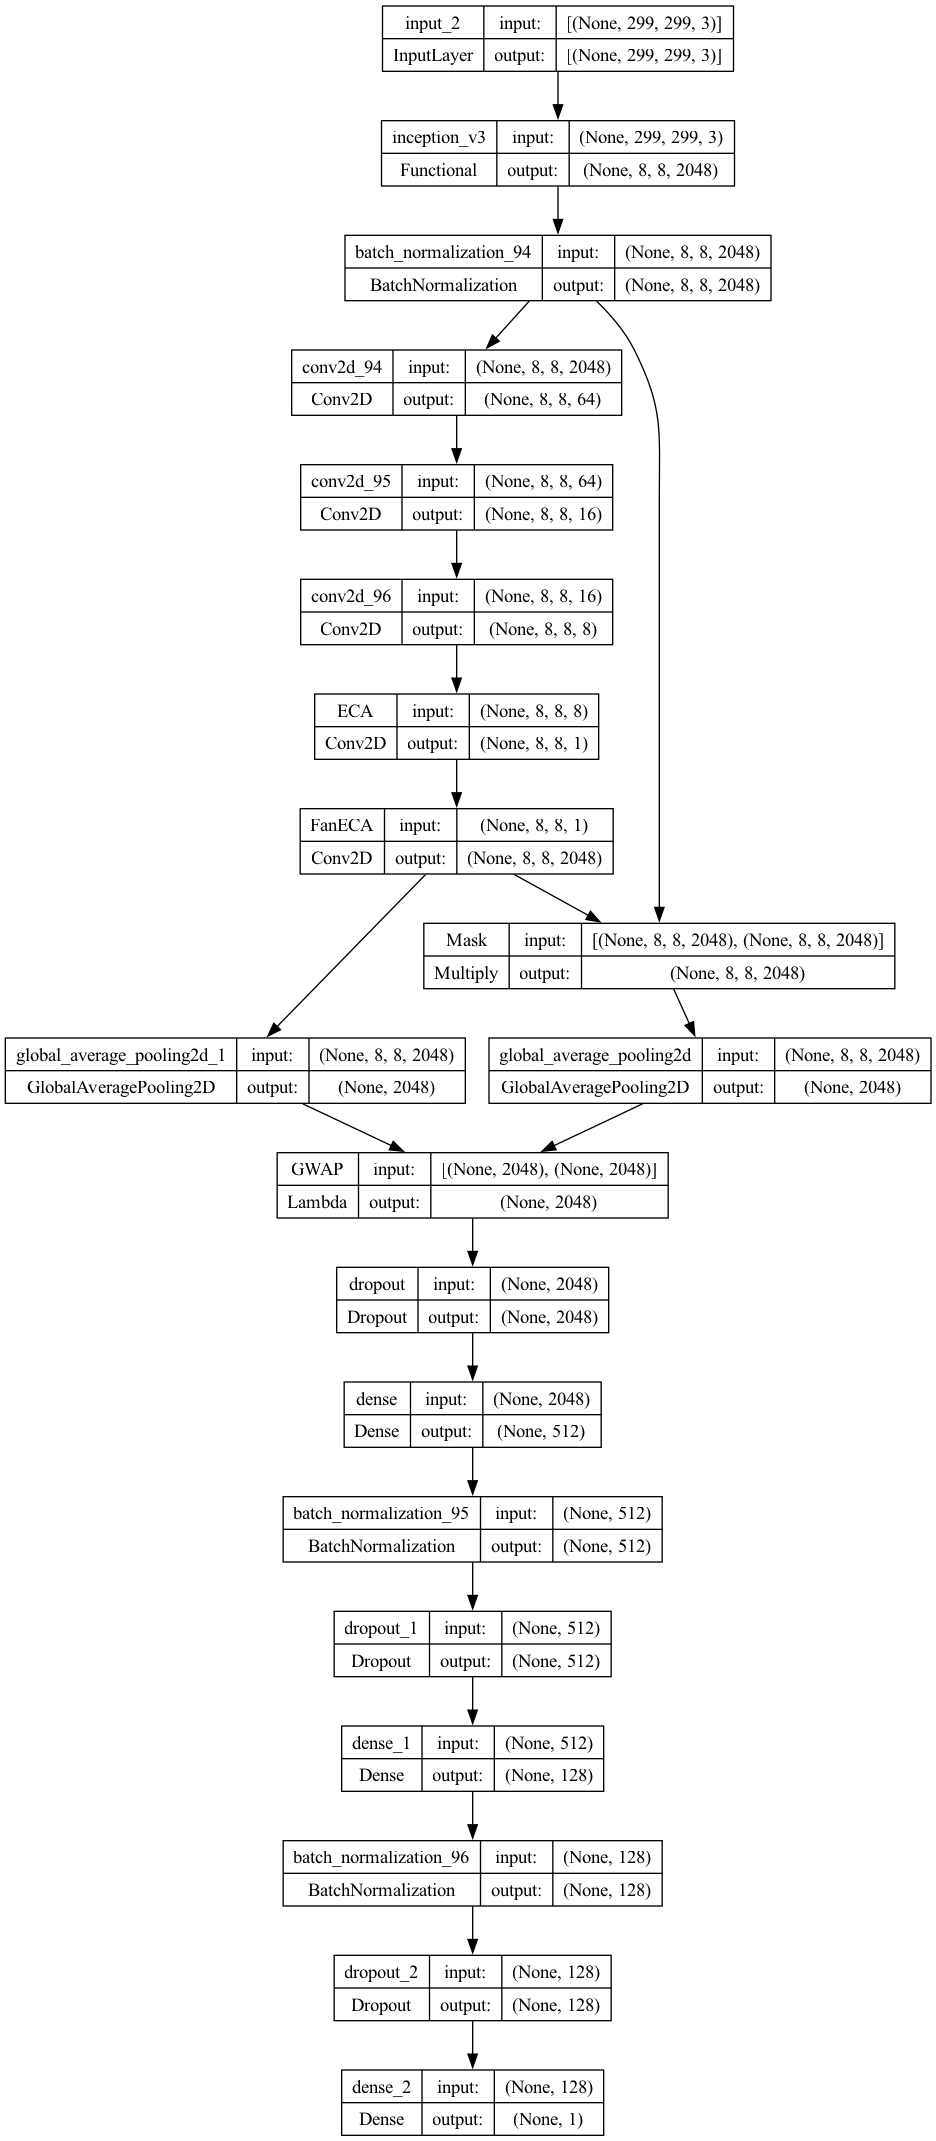

In [7]:
def build_model(input_shape: tuple) -> tf.keras.Model:
    # Create and freeze the pretrained model
    base_model = BaseModel(input_shape=input_shape, weights='imagenet', include_top=False)
    base_model.trainable = False

    # Model input
    inputs = tf.keras.layers.Input(input_shape)

    # Proccess the pretrained model
    bm = base_model(inputs)
    bm_bn = tf.keras.layers.BatchNormalization()(bm)

    # Build an Efficient Channel Attention between the pretrained model and the fully connected layers
    att = tf.keras.layers.Conv2D(64, kernel_size=(1, 1), padding='same', activation='relu')(bm_bn)
    att = tf.keras.layers.Conv2D(16, kernel_size=(1, 1), padding='same', activation='relu')(att)
    att = tf.keras.layers.Conv2D(8, kernel_size=(1, 1), padding='same', activation='relu')(att)
    att = tf.keras.layers.Conv2D(1, kernel_size=(1, 1), padding='valid', activation='sigmoid', name='ECA')(att)

    # Apply the ECA to all channels
    bm_depth = base_model.output_shape[-1]
    up_c2_w = np.ones((1, 1, 1, bm_depth))
    up_c2 = tf.keras.layers.Conv2D(
        bm_depth,
        kernel_size=(1, 1),
        padding='same',
        activation='linear',
        use_bias=False,
        weights=[up_c2_w],
        name='FanECA'
    )
    up_c2.trainable = False
    att_fan = up_c2(att)

    # Create a mask in order to account for missing values from the ECA
    mask_output = tf.keras.layers.multiply([att_fan, bm_bn], name='Mask')
    gap_mask = tf.keras.layers.GlobalAveragePooling2D()(mask_output)
    gap_att = tf.keras.layers.GlobalAveragePooling2D()(att_fan)
    gap = tf.keras.layers.Lambda(lambda x: x[0] / x[1], name='GWAP')([gap_mask, gap_att])
    gap_dr = tf.keras.layers.Dropout(0.3)(gap)

    # Create the top model fully connected layers
    x = tf.keras.layers.Dense(512, activation='relu')(gap_dr)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    # Model output
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    
    return model

model = build_model(input_shape)

clear_output(wait=True)
tf.keras.utils.plot_model(
    model,
    to_file=f'{cv_path}/model-{base}.png',
    show_shapes=True
)

### Split image dataset

Create the image generators for the training and testing sets.

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    featurewise_center = False,
    samplewise_center = False,
    rotation_range = 45,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.01,
    zoom_range = [0.9, 1.25],
    brightness_range = [0.75, 1.25],
    horizontal_flip = True,
    vertical_flip = True
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print('Image generators created!')

Image generators created!


In [9]:
# Generate the dataframe of images
x = []
y = []
for k, v in classes.items():
    folder = '{}/{}'.format(img_path, v)
    files = os.listdir(folder)
    for f in files:
        if f.startswith(v):
            x.append('{}/{}'.format(v, f))
            y.append(int(k))

x = np.array(x)
y = np.array(y)

df = pd.DataFrame(np.stack((x, y), axis=-1), columns=['filename', 'class']).sample(frac=1, random_state=SEED).reset_index(drop=True)
df_split = df[~df.filename.isin(pred_images)].reset_index(drop=True)
df_pred = df[df.filename.isin(pred_images)].reset_index(drop=True)

values = df['class'].astype(int).map(classes).value_counts(dropna=False)

print(f'Total: {values.sum()}')
for v, t in values.items():
    r = 100 * t / values.sum()
    print(f'    {v}: {t:,} ({r:0.2f}%)')
print()

df

Total: 307
    fertile: 184 (59.93%)
    infertile: 123 (40.07%)



filename class
0        fertile/fertile-21.jpg     1
1        fertile/fertile-59.png     1
2        fertile/fertile-41.png     1
3       fertile/fertile-111.jpg     1
4       fertile/fertile-123.jpg     1
..                          ...   ...
302  infertile/infertile-86.png     0
303      fertile/fertile-62.png     1
304      fertile/fertile-78.jpg     1
305  infertile/infertile-70.png     0
306      fertile/fertile-79.jpg     1

[307 rows x 2 columns]

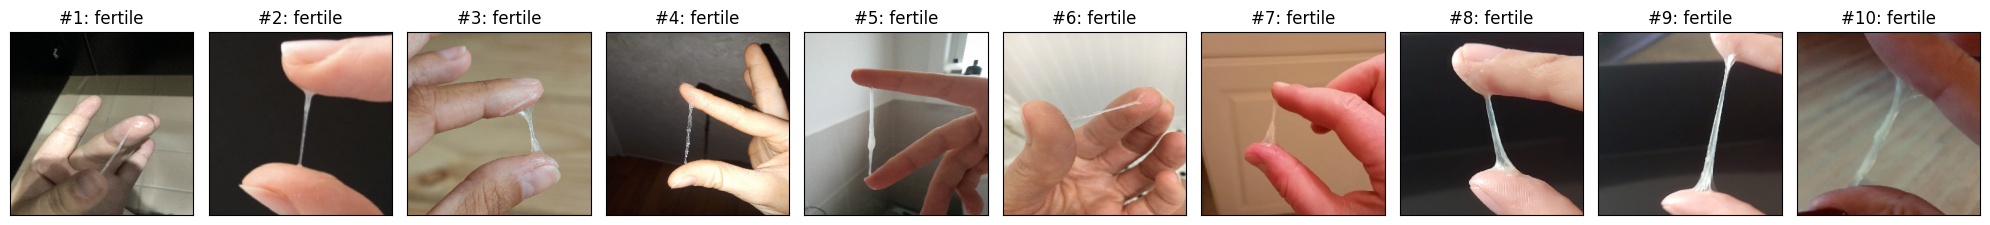

In [10]:
# Plot a sample of labeled images
n_show = 10

x, y = get_df_images(df, n_show)
show_images = {f'#{i + 1}: {classes[int(y[i])]}': x[i] for i in np.arange(n_show)}

plot_image(
    show_images,
    ncols=n_show
)

### Fit the model using cross-validation

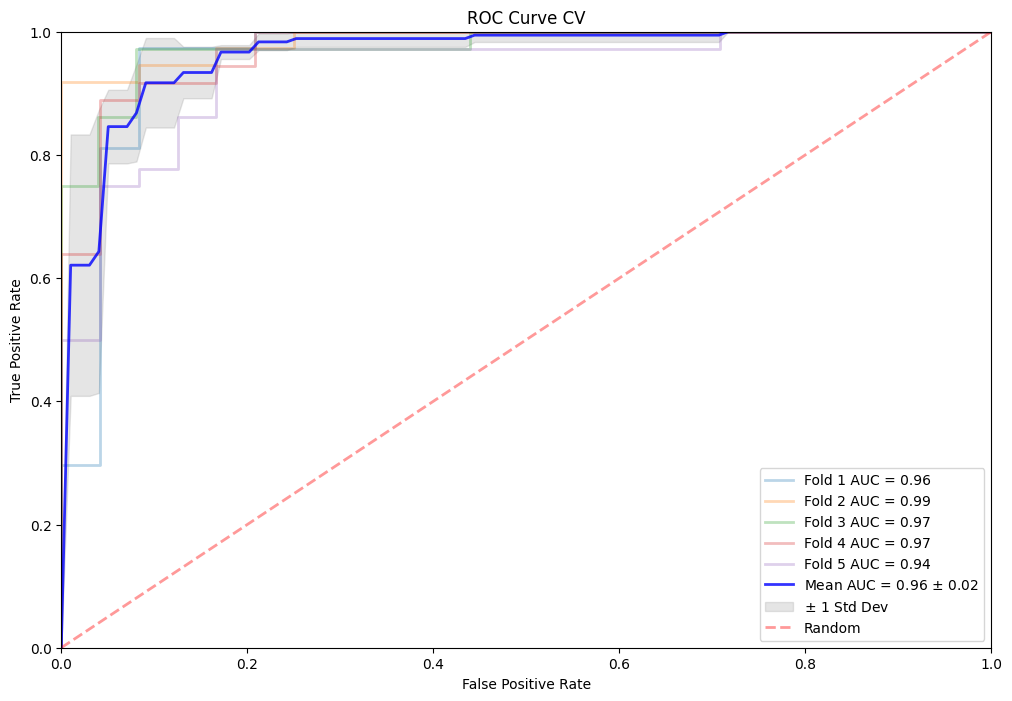

In [11]:
cv_results = {
    'score': {
        'roc_auc': [],
        'accuracy': []
    },
    'validation': {
        'true': [],
        'pred': [],
        'thr': []
    },
    'estimator': []
}

if fit_model:
    if test_size is not None:
        cv = StratifiedShuffleSplit(n_splits=cv_folds, test_size=test_size, random_state=SEED)
    else:
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=SEED)

    for i, (train, test) in enumerate(cv.split(df_split['filename'].values, df_split['class'].values)):
        print(f'Fold {i + 1}')
        tf.keras.backend.clear_session()

        df_train = df_split.loc[train]
        df_test = df_split.loc[test]

        train_generator = train_datagen.flow_from_dataframe(
            df_train,
            directory=img_path,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            seed=SEED
        )

        test_generator = test_datagen.flow_from_dataframe(
            df_test,
            directory=img_path,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            class_mode='binary',
            shuffle=False
        )

        model = build_model(input_shape)

        nant = tf.keras.callbacks.TerminateOnNaN()
        checkp = tf.keras.callbacks.ModelCheckpoint(f'{cv_path}/weights-{base}-{i + 1}.h5', save_best_only=True, save_weights_only=True, verbose=0)
        logh = tf.keras.callbacks.CSVLogger(f'{cv_path}/history-logs-{base}-{i + 1}.csv')
        redlr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=epochs//3, min_lr=1e-5, verbose=1)
        estop = tf.keras.callbacks.EarlyStopping(patience=epochs//2)
        tplot = TrainingPlot(path=f'{cv_path}/history-eval-{base}-{i + 1}.png', show=False, ncols=2)

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=[
                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                tf.keras.metrics.AUC(name='roc_auc')
            ]
        )

        model.fit_generator(
            train_generator,
            steps_per_epoch=train_generator.samples//batch_size,
            validation_data=test_generator,
            validation_steps=test_generator.samples//batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[nant, checkp, logh, redlr, estop, tplot]
        )

        y_hat = model.predict_generator(
            test_generator,
            verbose=1
        )

        y_true = np.array(test_generator.labels)
        y_pred = y_hat[:, 0]

        thr, _, _, _, _ = precision_recall(y_true, y_pred)
        y_bin = (y_pred > thr).astype(int)

        roc_auc = metrics.roc_auc_score(y_true, y_pred)
        accuracy = metrics.accuracy_score(y_true, y_bin)

        cv_results['score']['roc_auc'].append(roc_auc)
        cv_results['score']['accuracy'].append(accuracy)

        cv_results['validation']['true'].append(y_true.tolist())
        cv_results['validation']['pred'].append(y_pred.tolist())
        cv_results['validation']['thr'].append(thr)

        cv_results['estimator'].append(model)

        clear_output(wait=True)
        plot_roc_curve_cv(cv_results['validation']['true'], cv_results['validation']['pred'], path=f'{cv_path}/roc-auc-cv-{base}.png')

    # Save CV results
    cv_save = cv_results.copy()
    del(cv_save['estimator'])

    with open(f'{cv_path}/results-cv-{base}.json', 'w') as fh:
        json.dump(cv_save, fh)
else:
    with open(f'{cv_path}/results-cv-{base}.json', 'r') as fh:
        cv_save = json.load(fh)

    cv_results.update(cv_save)
    for i in np.arange(cv_folds):
        tf.keras.backend.clear_session()

        model = build_model(input_shape)
        model.load_weights(f'{cv_path}/weights-{base}-{i + 1}.h5')

        cv_results['estimator'].append(model)

        clear_output(wait=True)
        plot_roc_curve_cv(cv_results['validation']['true'], cv_results['validation']['pred'], path=f'{cv_path}/roc-auc-cv-{base}.png')

### Results

In [12]:
roc_auc = cv_results['score']['roc_auc']
accuracy = cv_results['score']['accuracy']

print(f'AUC: {np.mean(roc_auc):0.4f} ± {np.std(roc_auc):0.4f} | ACC: {np.mean(accuracy):0.4f} ± {np.std(accuracy):0.4f}')

AUC: 0.9660 ± 0.0162 | ACC: 0.9372 ± 0.0167


In [13]:
cv_best = np.argmax(roc_auc)
cv_model = cv_results['estimator'][cv_best]

y_true = cv_results['validation']['true'][cv_best]
y_pred = cv_results['validation']['pred'][cv_best]
thr = cv_results['validation']['thr'][cv_best]

print(f'Fold: {cv_best + 1} | AUC: {roc_auc[cv_best]:0.4f} | ACC: {accuracy[cv_best]:0.4f}')

Fold: 2 | AUC: 0.9865 | ACC: 0.9508


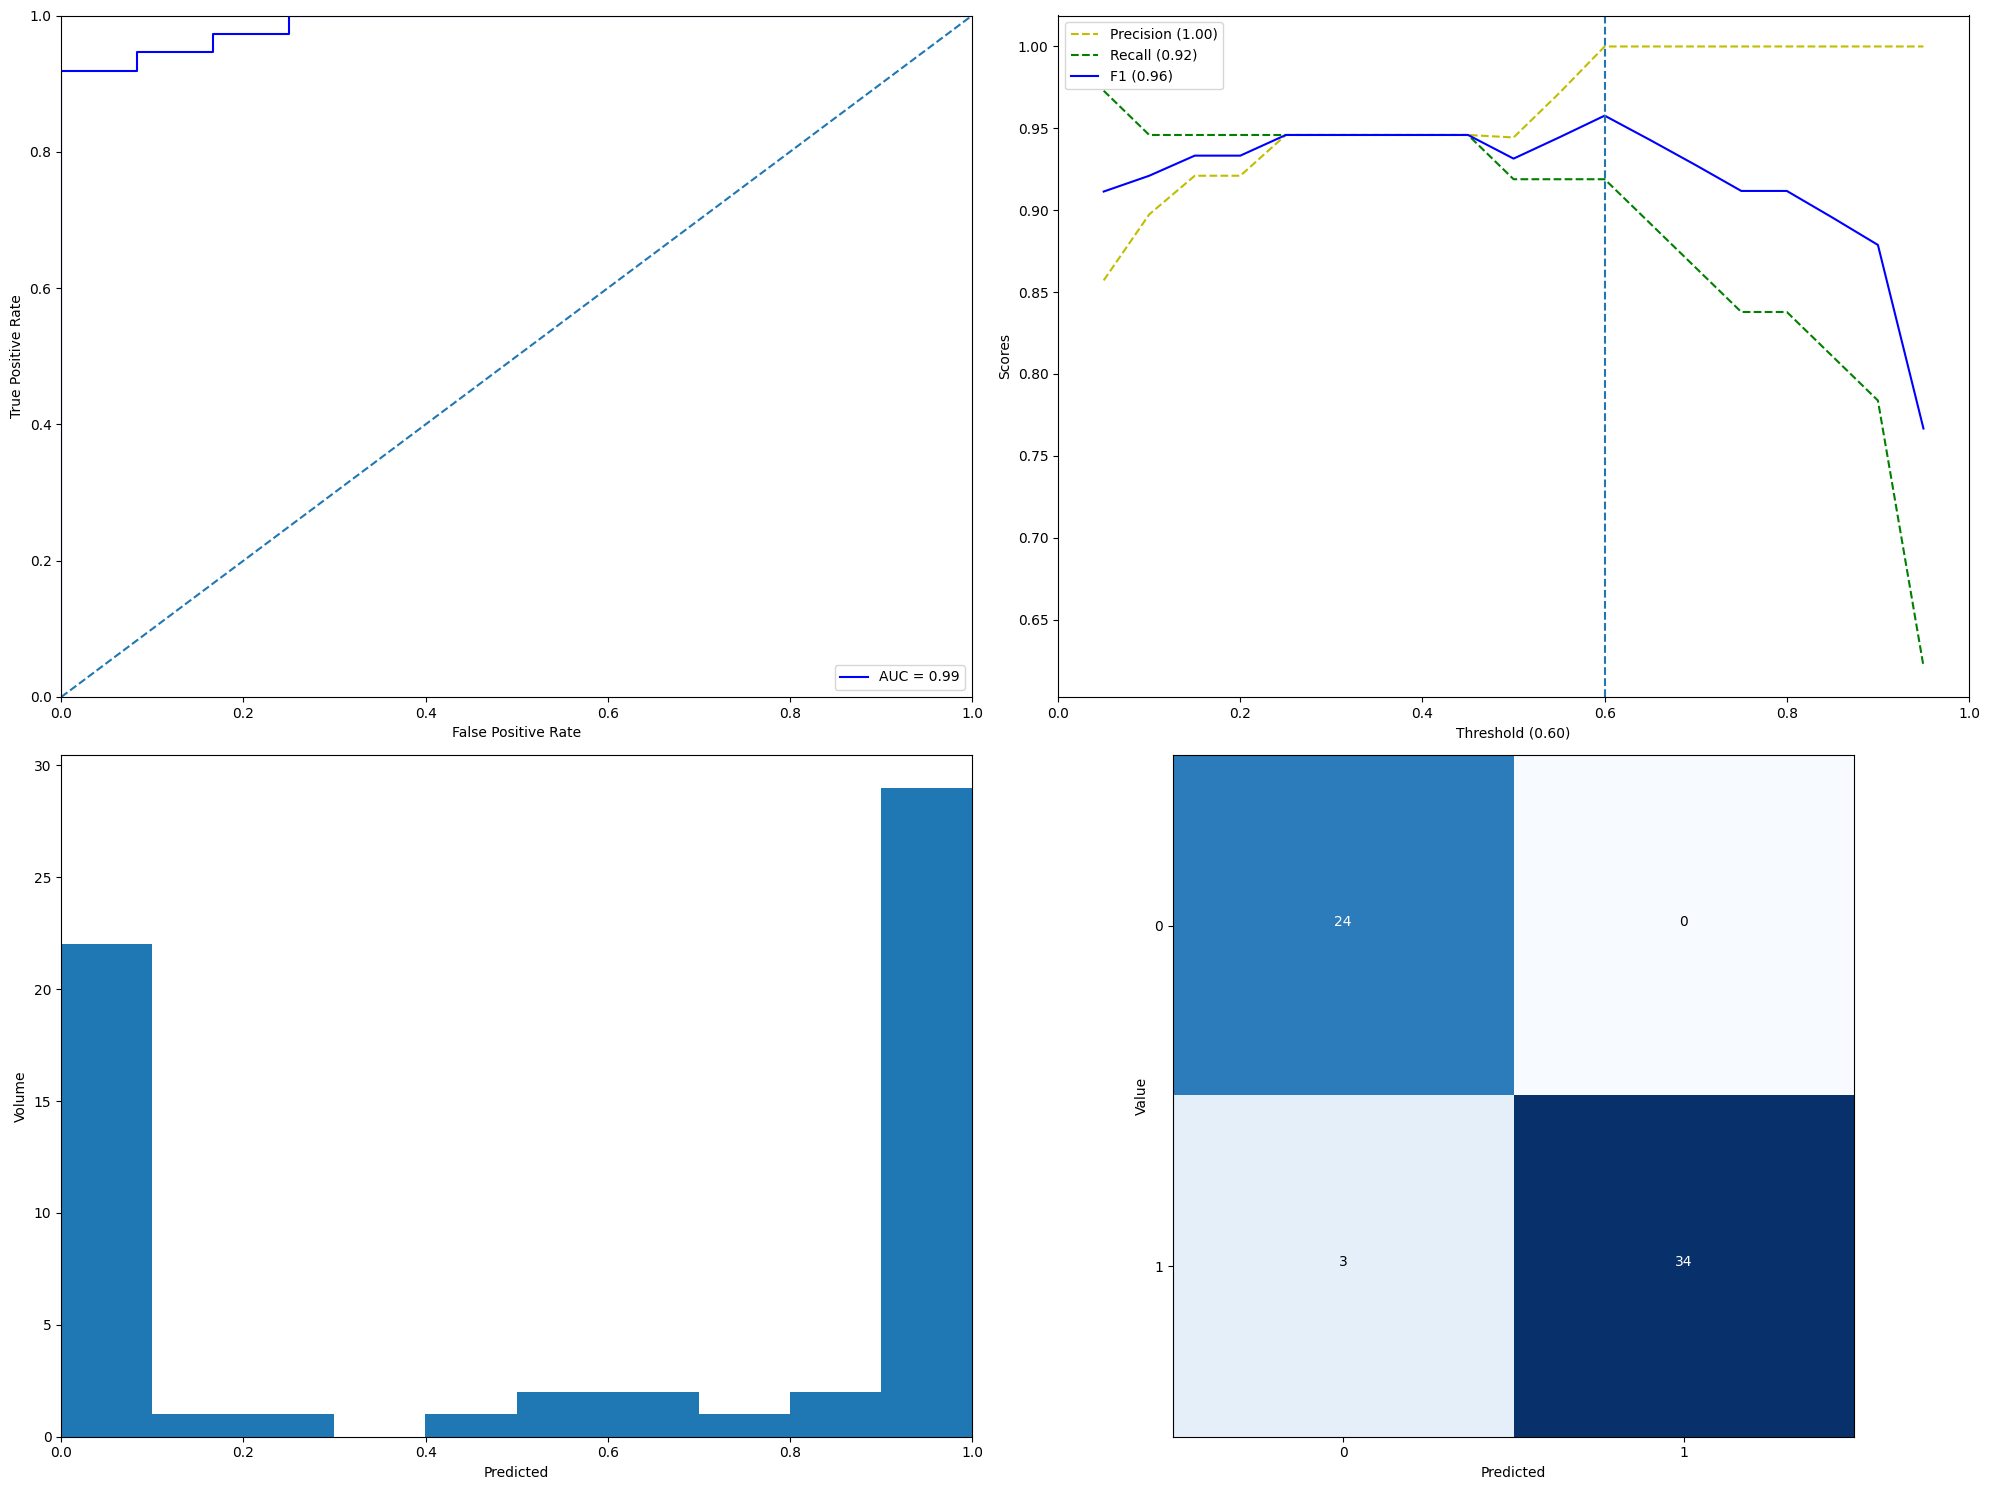

In [14]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), constrained_layout=True)
axes = ax.flatten()

draw_roc_curve(y_true, y_pred, ax=axes[0])
draw_precision_recall(y_true, y_pred, ax=axes[1])
draw_prediction_histogram(y_pred, ax=axes[2])
draw_confusion_matrix(y_true, y_pred, thr=thr, ax=axes[3])

fig.tight_layout()
plt.show()
fig.savefig(f'{path}/cv/scores-{base}.png')
plt.close()

### Model visualization (filter overlays)

In [15]:
pred_generator = test_datagen.flow_from_dataframe(
    df_pred,
    directory=f'{path}/cm_dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Get model prediction results
y_hat = cv_model.predict_generator(
    pred_generator,
    verbose=1
)

y_true = np.array(pred_generator.labels)
y_pred = y_hat[:, 0]
y_bin = (y_pred > thr).astype(int)

results = pd.DataFrame({
    'true': y_true,
    'pred': y_pred,
    'bin': y_bin
})

results

Found 4 validated image filenames belonging to 2 classes.
1/1 [==============================] - 1s 884ms/step


true      pred  bin
0     1  0.993264    1
1     1  0.999841    1
2     0  0.476334    0
3     0  0.035238    0

In [16]:
# Extract model SHAP values
bg_generator = test_datagen.flow_from_dataframe(
    df,
    directory=f'{path}/cm_dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

shap_bg, _ = get_generator_images(bg_generator)
x, _ = get_generator_images(pred_generator)

shap_model = shap.GradientExplainer(cv_model, shap_bg, batch_size=batch_size)
shap_values = shap_model.shap_values(x)[0]
    
print(shap_values.shape)

Found 307 validated image filenames belonging to 2 classes.
(4, 299, 299, 3)


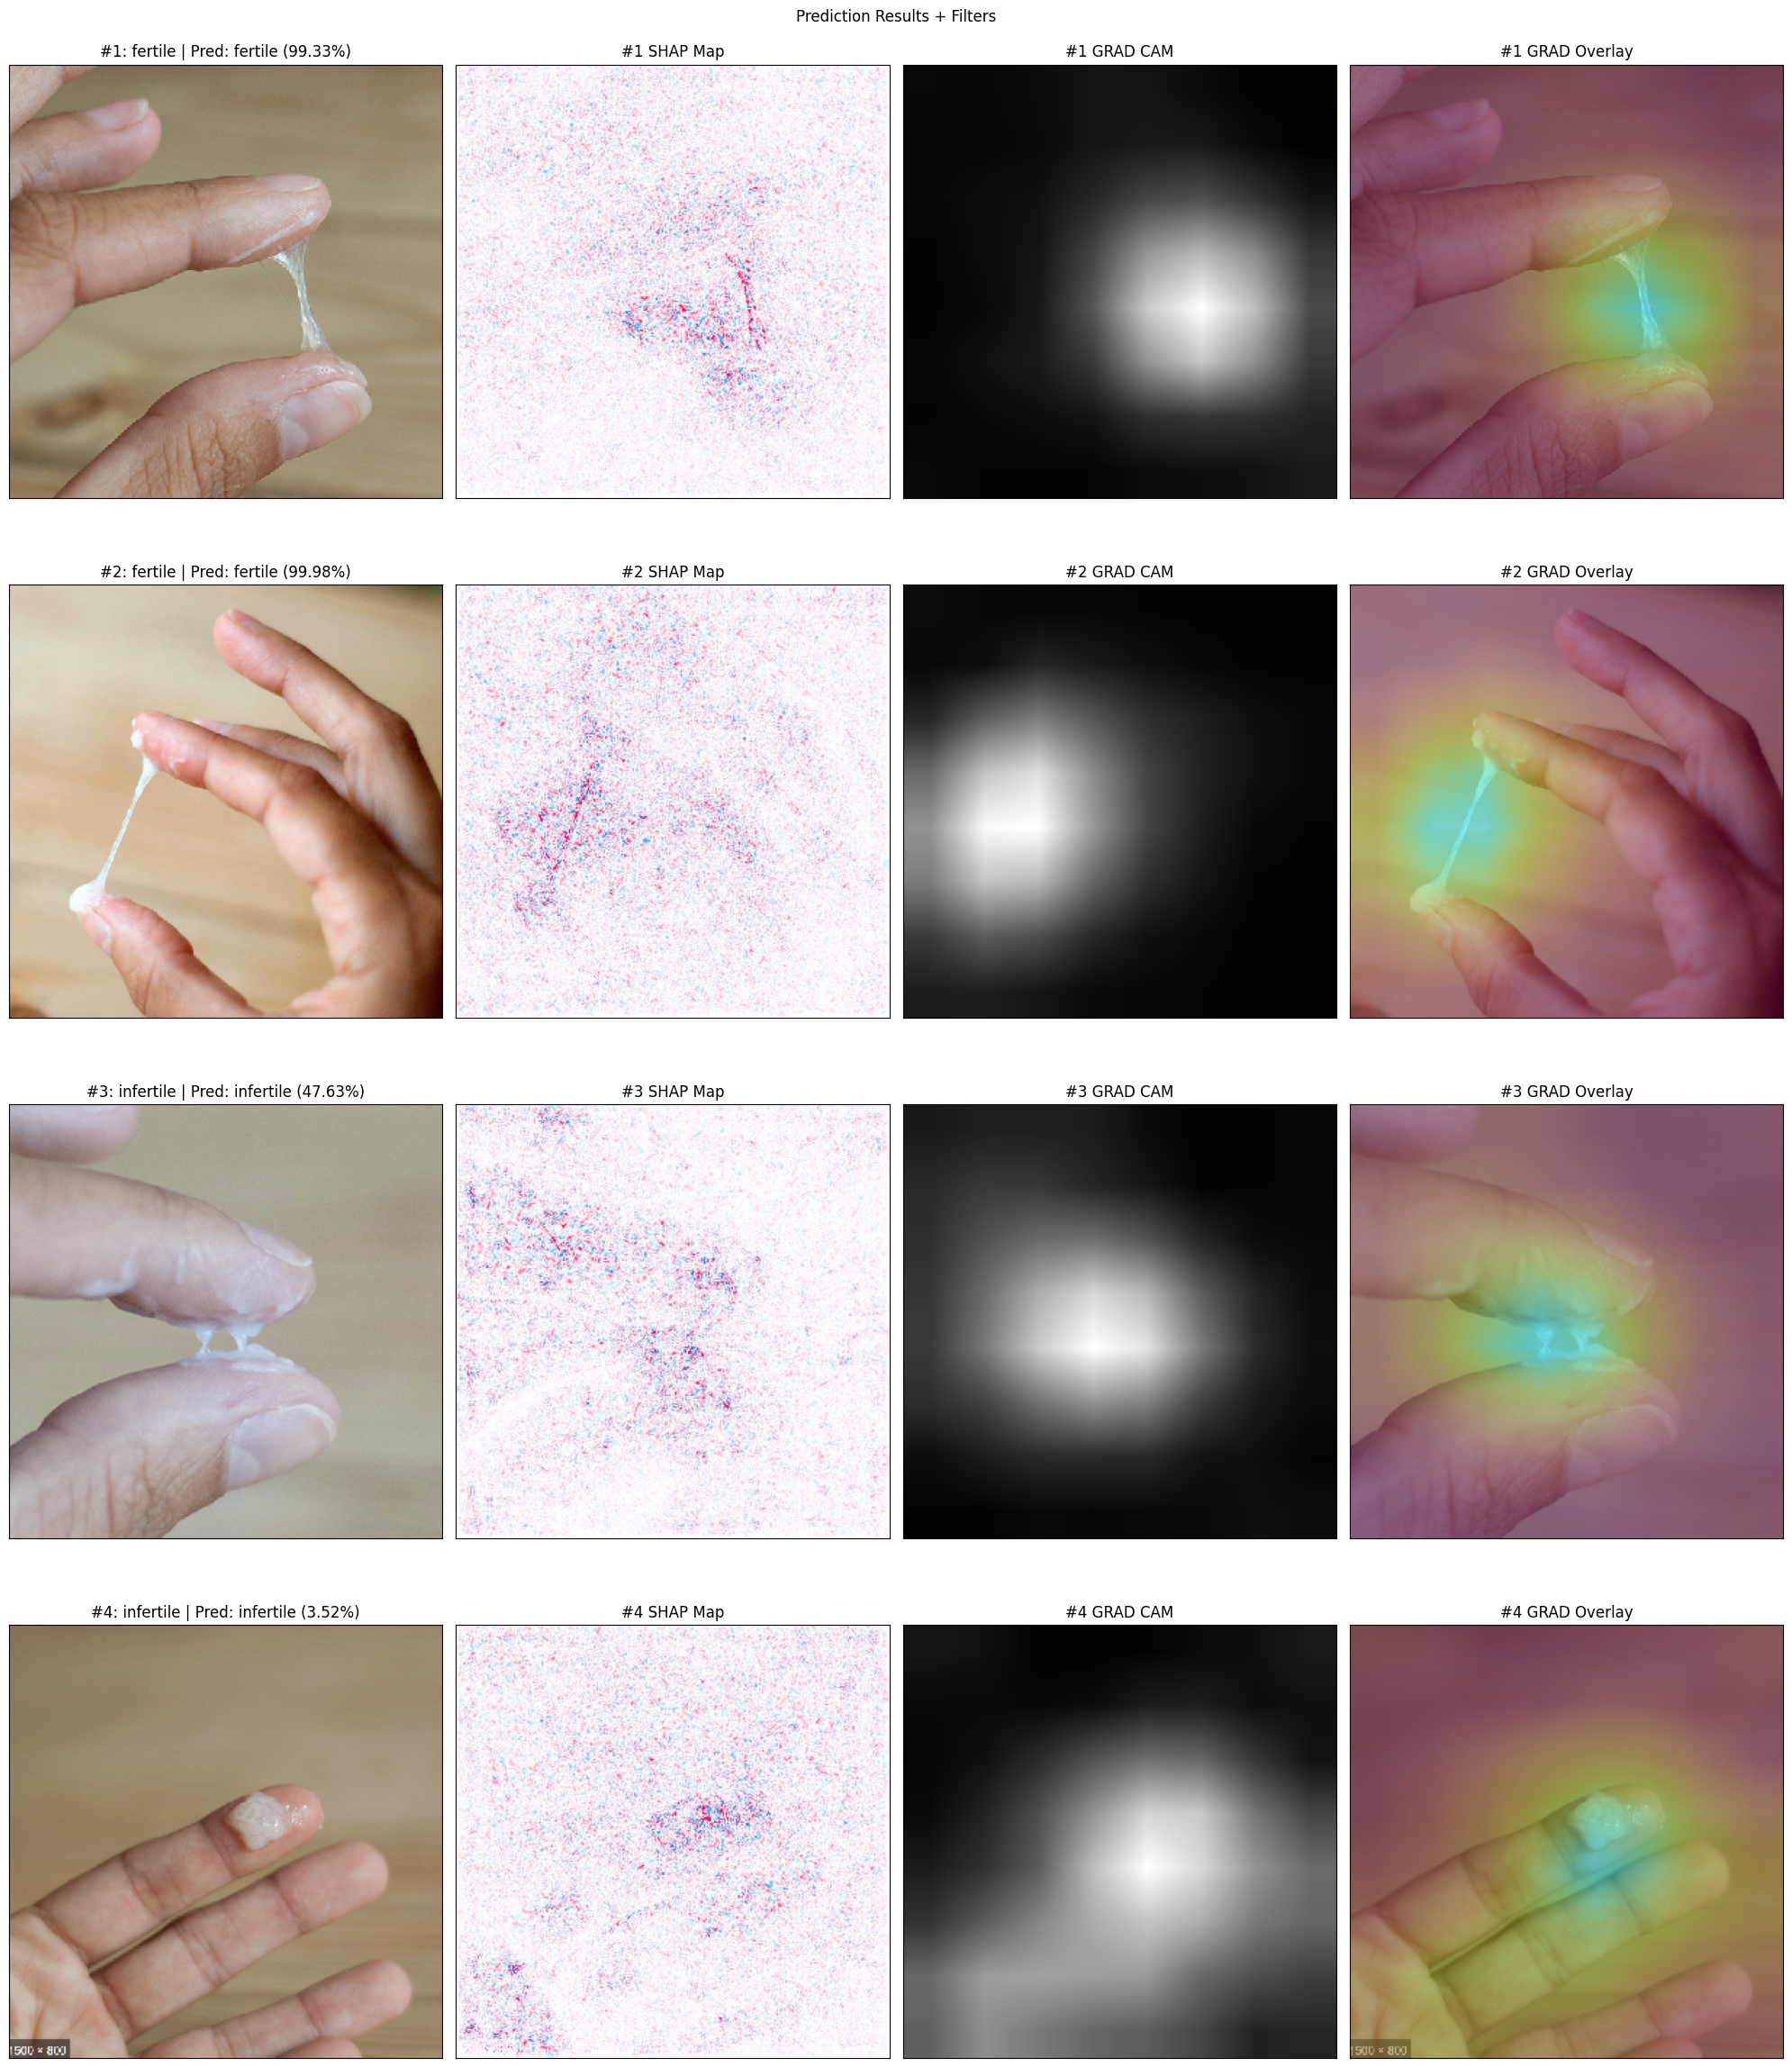

In [20]:
show_images = {}

# Get images for prediction
images, _ = get_df_images(df_pred)

for i in np.arange(pred_generator.samples):
    # Compute image GRAM heatmap
    grad_cam = compute_grad_cam(cv_model, x[i], layer_name=None)
    grad_overlay = overlay_grad_cam(grad_cam, images[i])
    
    # Compute image SHAP heatmap
    shap_map = compute_shap_map(shap_values[i])
    
    show_images = {
        **show_images,
        **{
            '#{:d}: {} | Pred: {} ({:0.2f}%)'.format(i + 1, classes[y_true[i]], classes[y_bin[i]], y_pred[i] * 100): images[i],
            '#{:d} SHAP Map'.format(i + 1): shap_map,
            '#{:d} GRAD CAM'.format(i + 1): grad_cam,
            '#{:d} GRAD Overlay'.format(i + 1): grad_overlay
        }
    }
    
plot_image(
    show_images,
    ncols=4,
    title='Prediction Results + Filters',
    path=f'{path}/cv/image-pred-results-{base}.png'
)